## Joint regularized inversion using ElasticSiameseFWI
Author: Ulises Berman & Omar Saad Aly

In this notebook, a joint baseline-monitor inversion is performed including the density parameter, using ElasticSiameseFWI.

In [1]:
from __future__ import print_function
import time
import torch
import torch.nn as nn
import numpy as np
import scipy.ndimage
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import deepwave
import os
from timeit import default_timer as timer
import scipy.io as spio
import math
import numpy as np
from utils.utils import *
from torch import optim
from IPython.core.debugger import set_trace 
import deepwave
from deepwave import elastic
import random

/home/bermanu/Ulises/miniconda3/envs/ElasticSiameseFWI/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set device
if torch.cuda.is_available():
    device=torch.device('cuda')
else:
    device=torch.device('cpu')
print(device)

cuda


In [3]:
# Print which device is used
print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
NVIDIA TITAN RTX
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [4]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled   = False

    return True

set_seed(0)   

True

In [5]:
####################################################
####   MAIN PARAMETERS FOR FORWARD MODELING         ####
####################################################

peak_freq = 8                    # central frequency
peak_source_time = 1 / peak_freq  # the time (in secs) of the peak amplitude
dx        = [20,20]         # step interval along x/z direction
dt        = 0.003                 # time interval (e.g., 3ms)
num_dims  = 2                     # dimension of velocity model
nz        = 94                   # model shape of z dimension (depth) Seam Arid
ny        = 400                   # model shape of y dimension Seam Arid
vmodel_dim = np.array([nz, ny])

total_t   = 6                      # totle sampling time (unit: s)
nt        = int(total_t / dt)       # number of time sampling points
pml_width  = [10,10,0,10]   # pml padding width for boundary (0 for free surface and 10 for absorbing boundary)
num_shots = 30                      # nunmber of shots
num_sources_per_shot = 1            # number of sources per shot
num_receivers_per_shot = 400       # number of receivers per shot
source_spacing = np.floor( ny / (num_shots))                         # space intervel between neigbouring sources
receiver_spacing = np.floor( ny / (num_receivers_per_shot))         # space intervel between neigbouring receivers
source_depth = 2               # the index depth of sources, default is 0 
receiver_depth = 0              # the index depths of receivers, default is 0

data_path = 'data/over_94_400.bin'

fwi_result = 'results/Overthrust_noise/'
# Loading the true model
base_true_vp = loadtruemodel(data_path, num_dims, vmodel_dim)
# Find where the water velocity ends and clip the models from that points
# model_vp, model_init_vp = loadinitmodel(initfile,device)
# The model will be updated during FWI
base_true_vs = vp_to_vs(base_true_vp)

base_true_rho = vp_to_rho(base_true_vp)*1000  # Convert to kg/m^3

# Convert models to numpy
base_true_vp = base_true_vp.cpu().numpy()
base_true_vs = base_true_vs.cpu().numpy()
base_true_rho = base_true_rho.cpu().numpy()

# Perturb velocity models
monitor_true_vp  = perturb_velocity_model(base_true_vp, center = (55, 110),lateral_extent = 30,vertical_layer_width = 4,
    max_vertical_extent_dilation = 60,compaction_magnitude = 250,dilation_magnitude = 120)
monitor_true_vp  = perturb_velocity_model(monitor_true_vp, center = (78, 310),lateral_extent = 40,vertical_layer_width = 5,
    max_vertical_extent_dilation = 70,compaction_magnitude = -250,dilation_magnitude = -120)

monitor_true_vs  = perturb_velocity_model(base_true_vs, center = (55, 110),lateral_extent = 30,vertical_layer_width = 4,
    max_vertical_extent_dilation = 60,compaction_magnitude = 250/np.sqrt(3),dilation_magnitude = 120/np.sqrt(3))
monitor_true_vs  = perturb_velocity_model(monitor_true_vs, center = (78, 310),lateral_extent = 40,vertical_layer_width = 5,
    max_vertical_extent_dilation = 70,compaction_magnitude = -250/np.sqrt(3),dilation_magnitude = -120/np.sqrt(3))

monitor_true_rho  = perturb_velocity_model(base_true_rho, center = (55, 110),lateral_extent = 30,vertical_layer_width = 4,
    max_vertical_extent_dilation = 60,compaction_magnitude = 40,dilation_magnitude = 16)
monitor_true_rho  = perturb_velocity_model(monitor_true_rho, center = (78, 310),lateral_extent = 40,vertical_layer_width = 5,
    max_vertical_extent_dilation = 70,compaction_magnitude = -40,dilation_magnitude = -16)


# Convert models to tensors and put them to device
base_true_vp = torch.from_numpy(base_true_vp).float().to(device)
base_true_rho = torch.from_numpy(base_true_rho).float().to(device)
base_true_vs = torch.from_numpy(base_true_vs).float().to(device)

In [6]:
# # Shift the value range
base_true_vp = denormalize_vp(normalize_vp(base_true_vp, vmin=base_true_vp.min(), vmax=base_true_vp.max()))
base_true_vs = denormalize_vs(normalize_vs(base_true_vs, vmin=base_true_vs.min(), vmax=base_true_vs.max()))
base_true_rho = denormalize_rho(normalize_rho(base_true_rho, vmin=base_true_rho.min(), vmax=base_true_rho.max()))

# Smoothed initial model for base
model_vp_base = torch.from_numpy(gaussian_filter(base_true_vp.detach().cpu().numpy(), sigma=[15,30])).to(device)
model_vs_base = torch.from_numpy(gaussian_filter(base_true_vs.detach().cpu().numpy(), sigma=[15,30])).to(device)
model_rho_base = torch.from_numpy(gaussian_filter(base_true_rho.detach().cpu().numpy(), sigma=[15,30])).to(device)

# Set all models to parameters
model_vp_base = nn.Parameter(model_vp_base)
model_vs_base = nn.Parameter(model_vs_base)
model_rho_base = nn.Parameter(model_rho_base)

In [7]:
# Set sources and array configuration
# x_s
x_s = torch.zeros(num_shots, num_sources_per_shot, 2,
                               dtype=torch.long, device=device)
x_s[..., 1] = source_depth
x_s[:, 0, 0] = (torch.arange(1, num_shots+1) * source_spacing)

# x_r
x_r = torch.zeros(num_shots, num_receivers_per_shot, 2,
                                 dtype=torch.long, device=device)
x_r[..., 1] = receiver_depth
x_r[:, :, 0] = (
    (torch.arange(num_receivers_per_shot) * receiver_spacing).repeat(num_shots, 1)
)

/tmp/ipykernel_1318/347311891.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout();


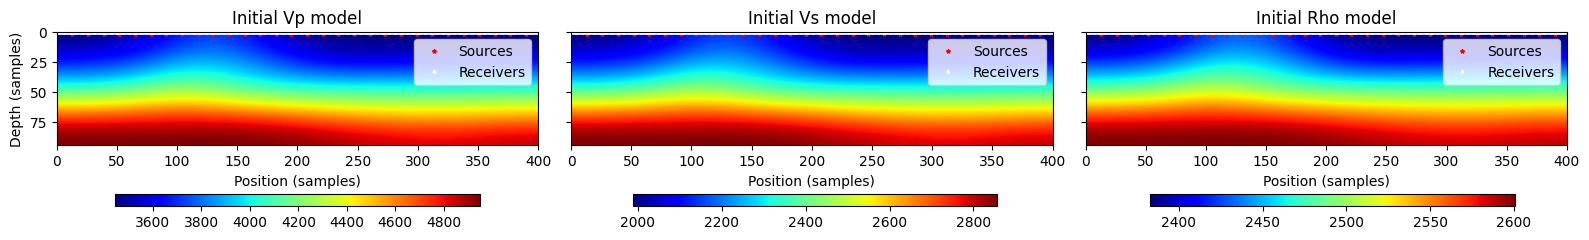

In [8]:
# Do a 1x3 plot showing true base, monitor and difference models
fig, axs = plt.subplots(1, 3, figsize=(16, 6), sharey=True)
# Plot true model
vmin=model_vp_base.detach().cpu().numpy().min()
vmax=model_vp_base.detach().cpu().numpy().max()
im = axs[0].imshow(model_vp_base.detach().cpu().numpy(), vmin=vmin, vmax=vmax, cmap='jet', \
              extent=[0, model_vp_base.shape[1], model_vp_base.shape[0], 0])
axs[0].set_title('Initial Vp model')
axs[0].set_xlabel('Position (samples)')
axs[0].set_ylabel('Depth (samples)')

pos = axs[0].get_position()
cbar_ax = fig.add_axes([pos.x0 - 0.05, pos.y0 - 0.12, pos.width, 0.02])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

# Plot monitor model
vmin=model_vs_base.detach().cpu().numpy().min()
vmax=model_vs_base.detach().cpu().numpy().max()
im = axs[1].imshow(model_vs_base.detach().cpu().numpy(), vmin=vmin, vmax=vmax, cmap='jet', \
                   extent=[0, model_vs_base.shape[1], model_vs_base.shape[0], 0])
axs[1].set_title('Initial Vs model')
axs[1].set_xlabel('Position (samples)')

pos = axs[1].get_position()
cbar_ax = fig.add_axes([pos.x0, pos.y0 - 0.12, pos.width, 0.02])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
# Plot difference model
vmin=model_rho_base.detach().cpu().numpy().min()
vmax=model_rho_base.detach().cpu().numpy().max()
im = axs[2].imshow(model_rho_base.detach().cpu().numpy(), vmin=vmin, vmax=vmax, cmap='jet', \
                   extent=[0, model_rho_base.shape[1], model_rho_base.shape[0], 0])
axs[2].set_title('Initial Rho model')
axs[2].set_xlabel('Position (samples)')

pos = axs[2].get_position()
cbar_ax = fig.add_axes([pos.x0 + 0.05, pos.y0 - 0.12, pos.width, 0.02])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
# Plot sources (red stars)
src_x = x_s[:, 0, 0].cpu().numpy()
src_z = x_s[:, 0, 1].cpu().numpy()
axs[0].plot(src_x, src_z, 'r*', markersize=3, label='Sources')
axs[1].plot(src_x, src_z, 'r*', markersize=3, label='Sources')
axs[2].plot(src_x, src_z, 'r*', markersize=3, label='Sources')
# Plot receivers (white triangles)
rec_x = x_r[0, :, 0].cpu().numpy()
rec_z = x_r[0, :, 1].cpu().numpy()
axs[0].plot(rec_x, rec_z, 'w^', markersize=2, label='Receivers')
axs[1].plot(rec_x, rec_z, 'w^', markersize=2, label='Receivers')
axs[2].plot(rec_x, rec_z, 'w^', markersize=2, label='Receivers')

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')
axs[2].legend(loc='upper right')
plt.tight_layout();

In [9]:
# source_amplitudes
source_amplitudes = (
    deepwave.wavelets.ricker(peak_freq, nt, dt, peak_source_time)
    .repeat(num_shots, num_sources_per_shot, 1)
    .to(device)
)

# Create observed data using true models
receiver_amplitudes_true = elastic(
    *deepwave.common.vpvsrho_to_lambmubuoyancy(base_true_vp.T, base_true_vs.T,
                                               base_true_rho.T),
    dx, dt,
    source_amplitudes_y=source_amplitudes,
    source_locations_y=x_s,
    receiver_locations_y=x_r,
    accuracy=4,
    pml_width=pml_width,
    pml_freq=peak_freq)[-2]

rcv_amps_true_base = highpass_filter(2.5, receiver_amplitudes_true.cpu(), dt=dt, pad=[10, 10, 0, 0, 0, 0]).to(device)
## Add noise to the rcv_amps_true
rcv_amps_true_base = add_awgn(rcv_amps_true_base, snr_db=5)

base_true_vp = base_true_vp.detach().cpu().numpy()
base_true_vs = base_true_vs.detach().cpu().numpy()
base_true_rho = base_true_rho.detach().cpu().numpy()

In [10]:
# Shift the value range
monitor_true_vp = denormalize_vp(normalize_vp(monitor_true_vp, vmin=monitor_true_vp.min(), vmax=monitor_true_vp.max()))
monitor_true_vs = denormalize_vs(normalize_vs(monitor_true_vs, vmin=monitor_true_vs.min(), vmax=monitor_true_vs.max()))
monitor_true_rho = denormalize_rho(normalize_rho(monitor_true_rho, vmin=monitor_true_rho.min(), vmax=monitor_true_rho.max()))

# Convert models to tensors but keep them on CPU for now
monitor_true_vp = torch.from_numpy(monitor_true_vp).float().to(device)
monitor_true_rho = torch.from_numpy(monitor_true_rho).float().to(device)
monitor_true_vs = torch.from_numpy(monitor_true_vs).float().to(device)

# Smoothed initial model for monitor
model_vp_mon = model_vp_base.clone()
model_vs_mon = model_vs_base.clone()
model_rho_mon = model_rho_base.clone()

# Convert to parameters
model_vp_mon = nn.Parameter(model_vp_mon)
model_vs_mon = nn.Parameter(model_vs_mon)
model_rho_mon = nn.Parameter(model_rho_mon)

# Create observed data using true models
receiver_amplitudes_true = elastic(
    *deepwave.common.vpvsrho_to_lambmubuoyancy(monitor_true_vp.T, monitor_true_vs.T,
                                               monitor_true_rho.T),
    dx, dt,
    source_amplitudes_y=source_amplitudes,
    source_locations_y=x_s,
    receiver_locations_y=x_r,
    accuracy=4,
    pml_width=pml_width,
    pml_freq=peak_freq)[-2]

monitor_true_vp = monitor_true_vp.detach().cpu().numpy()
monitor_true_vs = monitor_true_vs.detach().cpu().numpy()
monitor_true_rho = monitor_true_rho.detach().cpu().numpy()

rcv_amps_true_mon = highpass_filter(2.5, receiver_amplitudes_true.cpu(), dt=dt, pad=[10, 10, 0, 0, 0, 0]).to(device)
## Add noise to the rcv_amps_true
rcv_amps_true_mon = add_awgn(rcv_amps_true_mon, snr_db=5)
rcv_amps_true_mon.shape

torch.Size([30, 400, 2000])

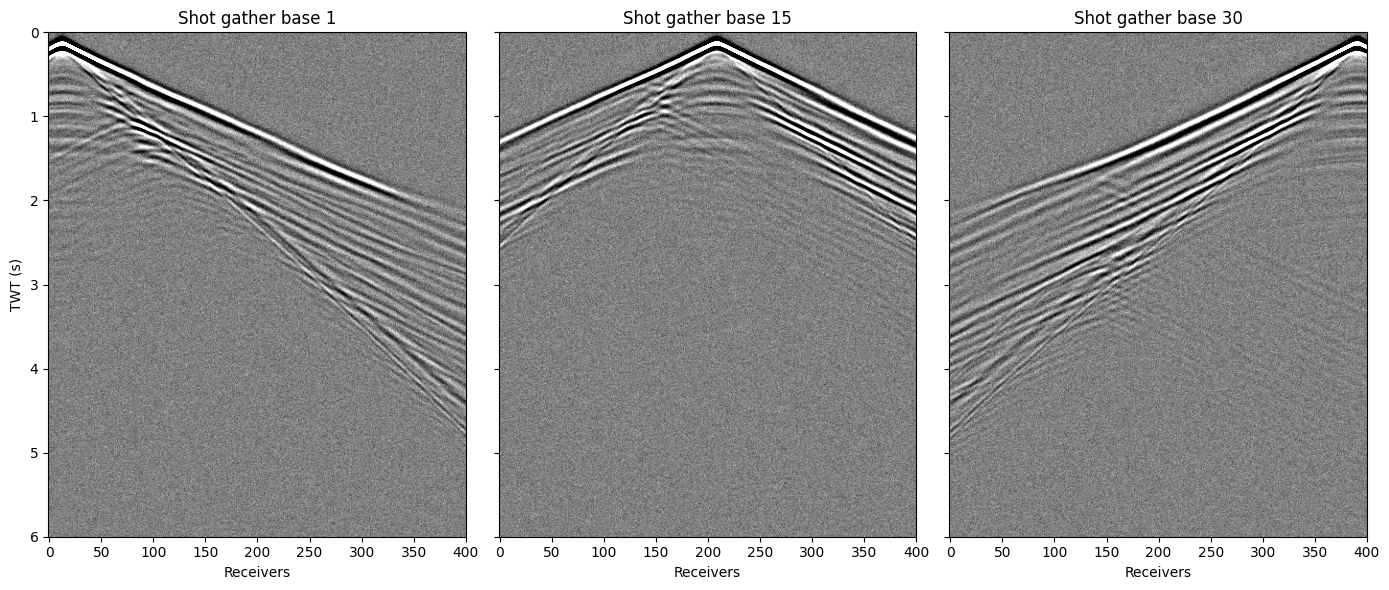

In [11]:
# Plot three shot gathers (beginning, middle and end of num_shots)
fig, axs = plt.subplots(1, 3, figsize=(14, 6), sharey=True)
vmax = 0.05*receiver_amplitudes_true.max()
vmin = -vmax
# Plot first shot gather
im = axs[0].imshow(rcv_amps_true_base[0, :, :].cpu().numpy().T, cmap='gray', aspect='auto',
                   extent=[-1, num_receivers_per_shot, nt*dt, 0], vmin=vmin, vmax=vmax)
axs[0].set_title('Shot gather base 1')
axs[0].set_xlabel('Receivers')
axs[0].set_ylabel('TWT (s)')
# Plot middle shot gather
im = axs[1].imshow(rcv_amps_true_base[num_shots // 2, :, :].cpu().numpy().T, cmap='gray', aspect='auto',
                   extent=[-1, num_receivers_per_shot, nt*dt, 0], vmin=vmin, vmax=vmax)
axs[1].set_title(f'Shot gather base {num_shots // 2}')
axs[1].set_xlabel('Receivers')
# Plot last shot gather
im = axs[2].imshow(rcv_amps_true_base[-1, :, :].cpu().numpy().T, cmap='gray', aspect='auto',
                   extent=[-1, num_receivers_per_shot, nt*dt, 0], vmin=vmin, vmax=vmax)
axs[2].set_title(f'Shot gather base {num_shots}')
axs[2].set_xlabel('Receivers')
plt.tight_layout();

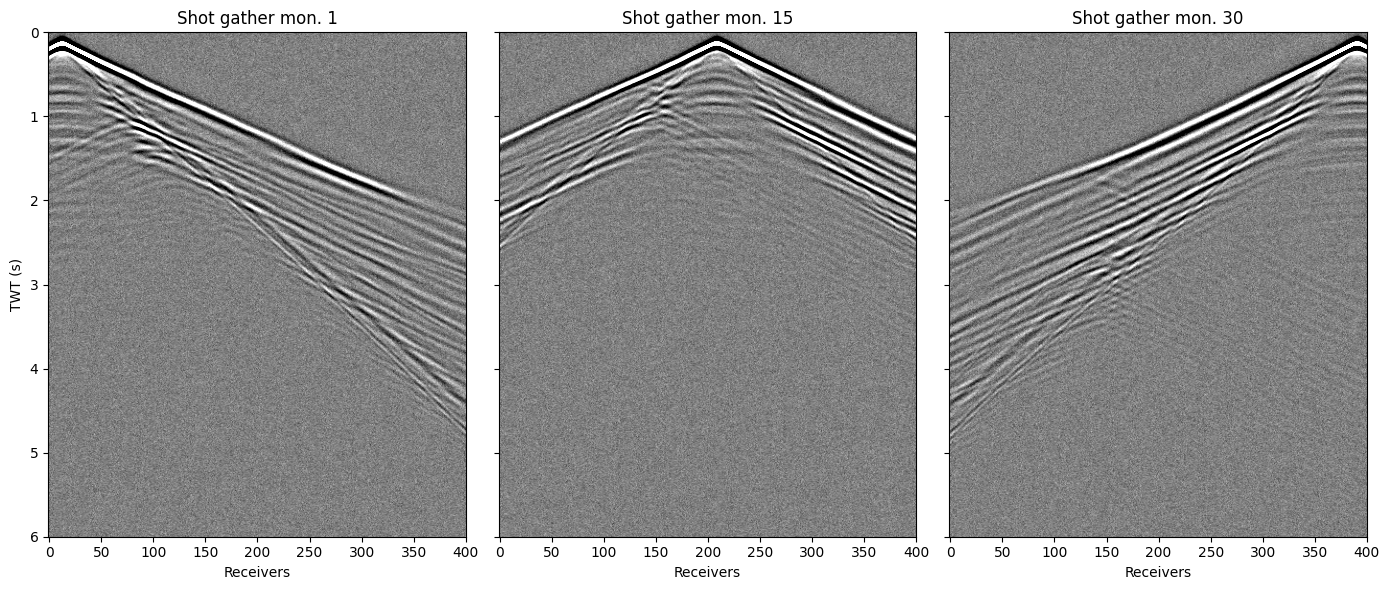

In [12]:
# Plot three shot gathers (beginning, middle and end of num_shots)
fig, axs = plt.subplots(1, 3, figsize=(14, 6), sharey=True)
vmax = 0.05*receiver_amplitudes_true.max()
vmin = -vmax
# Plot first shot gather
im = axs[0].imshow(rcv_amps_true_mon[0, :, :].cpu().numpy().T, cmap='gray', aspect='auto',
                   extent=[-1, num_receivers_per_shot, nt*dt, 0], vmin=vmin, vmax=vmax)
axs[0].set_title('Shot gather mon. 1')
axs[0].set_xlabel('Receivers')
axs[0].set_ylabel('TWT (s)')
# Plot middle shot gather
im = axs[1].imshow(rcv_amps_true_mon[num_shots // 2, :, :].cpu().numpy().T, cmap='gray', aspect='auto',
                   extent=[-1, num_receivers_per_shot, nt*dt, 0], vmin=vmin, vmax=vmax)
axs[1].set_title(f'Shot gather mon. {num_shots // 2}')
axs[1].set_xlabel('Receivers')
# Plot last shot gather
im = axs[2].imshow(rcv_amps_true_mon[-1, :, :].cpu().numpy().T, cmap='gray', aspect='auto',
                   extent=[-1, num_receivers_per_shot, nt*dt, 0], vmin=vmin, vmax=vmax)
axs[2].set_title(f'Shot gather mon. {num_shots}')
axs[2].set_xlabel('Receivers')
plt.tight_layout();

In [13]:
# Learning rates
fwi_lrp            = 30        # learning rate for updating the model.
fwi_lrs            = 10        # learning rate for updating the model.
fwi_lrrho            = 2       # learning rate for updating the model.

fwi_batch         =   num_shots      # number of batches for FWI.
fwi_num_epochs    = 166      # number of FWI iteration.
sim_lr            = 1*1e-5   # learning rate for Soamese network.
savepoch = 15                 # Saving models each 50 FWI iterations

In [14]:
from torchsummary import summary
from Model.Module22_644 import *

#Learning Schedule
def lr_lambda(epoch):
    return 1/2

### optimizer for the velocity model
optimizerp_base = optim.Adam([{'params': model_vp_base, 'lr':fwi_lrp, 'betas':(0.5, 0.99), 'eps':1e-8,
                          'weight_decay':0}])
optimizers_base = optim.Adam([{'params': model_vs_base, 'lr':fwi_lrs, 'betas':(0.5, 0.99), 'eps':1e-8,
                          'weight_decay':0}])
optimizerrho_base = optim.Adam([{'params': model_rho_base, 'lr':fwi_lrrho, 'betas':(0.5, 0.99), 'eps':1e-8,
                          'weight_decay':0}])

optimizerp_mon = optim.Adam([{'params': model_vp_mon, 'lr':fwi_lrp, 'betas':(0.5, 0.99), 'eps':1e-8,
                            'weight_decay':0}])
optimizers_mon = optim.Adam([{'params': model_vs_mon, 'lr':fwi_lrs, 'betas':(0.5, 0.99), 'eps':1e-8,
                            'weight_decay':0}])
optimizerrho_mon = optim.Adam([{'params': model_rho_mon, 'lr':fwi_lrrho, 'betas':(0.5, 0.99), 'eps':1e-8,
                            'weight_decay':0}])

#Best
#leak_value = 0.0001
leak_value = 0.00001
D1 = 1
netD = SiameseNetwork(D1)
### init the hyper-parameters of netD ###
netD = netD.apply(lambda m: weights_init(m, leak_value))
netD = netD.to(device)

# Optimizer for Siamese network.
optim_s = optim.Adam(netD.parameters(),lr=sim_lr,betas=(0.5, 0.99), \
                    eps=1e-6, weight_decay=0)

schedulerp_base = torch.optim.lr_scheduler.MultiplicativeLR(optimizerp_base, lr_lambda=lr_lambda)
schedulerp_mon = torch.optim.lr_scheduler.MultiplicativeLR(optimizerp_mon, lr_lambda=lr_lambda)

schedulers_base = torch.optim.lr_scheduler.MultiplicativeLR(optimizers_base, lr_lambda=lr_lambda)
schedulers_mon = torch.optim.lr_scheduler.MultiplicativeLR(optimizers_mon, lr_lambda=lr_lambda)

schedulerrho_base = torch.optim.lr_scheduler.MultiplicativeLR(optimizerrho_base, lr_lambda=lr_lambda)
schedulerrho_mon = torch.optim.lr_scheduler.MultiplicativeLR(optimizerrho_mon, lr_lambda=lr_lambda)

"""Compute number of parameters"""
s  = sum(np.prod(list(p.size())) for p in netD.parameters())
print ('Number of netD params: %d' % s)

summary(netD,[(4,nt,num_receivers_per_shot),(4,nt,num_receivers_per_shot)])

############## Init  ################# 
SNRP = 0.0
SSIMP = 0.0
ERRORP = 0.0

SNRS = 0.0
SSIMS = 0.0
ERRORS = 0.0

SNRrho = 0.0
SSIMrho = 0.0
ERRORrho = 0.0

Loss = 0.0

Number of netD params: 5432


[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 4, 2000, 400]             148
         LeakyReLU-2         [-1, 4, 2000, 400]               0
            Conv2d-3         [-1, 4, 2000, 400]             148
         LeakyReLU-4         [-1, 4, 2000, 400]               0
            Conv2d-5         [-1, 8, 2000, 400]             296
         LeakyReLU-6         [-1, 8, 2000, 400]               0
            Conv2d-7        [-1, 16, 2000, 400]             592
         LeakyReLU-8        [-1, 16, 2000, 400]               0
            Conv2d-9         [-1, 8, 2000, 400]             296
        LeakyReLU-10         [-1, 8, 2000, 400]               0
           Conv2d-11         [-1, 4, 2000, 400]             148
        LeakyReLU-12         [-1, 4, 2000, 400]               0
           Conv2d-13         [-1, 4, 2000, 400]             148
        LeakyReLU-14         [-1, 4, 20

In [15]:
import ptwt
import pywt
import torch.nn.functional as F
# Starting the FWI loop.
# global model_vp, model_vs, model_rho, source_amplitudes_init, SNRP, SSIMP, Loss, ERRORS, SNRS, SSIMS, ERRORS, SNRrho, SSIMrho, ERRORrho

# Scaling factor
ma_base = 1/rcv_amps_true_base.max().detach().cpu().numpy()
con_base = 10*ma_base

ma_mon = 1/rcv_amps_true_mon.max().detach().cpu().numpy()
con_mon = 10*ma_mon

t_start = time.time()
# number of shots per batch
num_shots_per_batch = int(num_shots / fwi_batch) 

for i in range(fwi_num_epochs):
    # initialization of the loss
    epoch_loss = 0.0

    for it in range(fwi_batch):
        iteration = i*fwi_batch+it+1
        # Set both optimizerps to zero grad.
        optimizerp_base.zero_grad()
        optimizers_base.zero_grad()
        optimizerrho_base.zero_grad()

        optimizerp_mon.zero_grad()
        optimizers_mon.zero_grad()
        optimizerrho_mon.zero_grad()
        
        netD.train()                
        netD.zero_grad() 
        
        # Forward modeling based on AWE (DeepWave).
        batch_x_s = x_s[it::fwi_batch].to(device)
        batch_x_r = x_r[it::fwi_batch].to(device)
        batch_src_amps = source_amplitudes[it::fwi_batch].to(device)

        batch_rcv_amps_true_base = rcv_amps_true_base[it::fwi_batch,:,:].to(device)
        batch_rcv_amps_true_base = con_base*batch_rcv_amps_true_base[0,:,:]
        #batch_rcv_amps_pred = prop(batch_src_amps, batch_x_s, batch_x_r, dt)
        batch_rcv_amps_pred = elastic( *deepwave.common.vpvsrho_to_lambmubuoyancy(model_vp_base.T, model_vs_base.T,
                                        model_rho_base.T),
                                        dx, dt,
                                        source_amplitudes_y=batch_src_amps,
                                        source_locations_y=batch_x_s,
                                        receiver_locations_y=batch_x_r,
                                        accuracy=4,
                                        pml_width=pml_width,
                                        pml_freq=peak_freq)[-2]

        coefficients = ptwt.wavedec2(batch_rcv_amps_true_base.T, pywt.Wavelet("haar"),
                                     level=2, mode="zero")
        d_real_base = torch.cat((coefficients[0][0,:,:].unsqueeze(0),coefficients[1][0][0,:,:].unsqueeze(0),coefficients[1][1][0,:,:].unsqueeze(0),coefficients[1][2][0,:,:].unsqueeze(0)),dim=0).unsqueeze(0)

        batch_rcv_amps_pred = con_base*batch_rcv_amps_pred[0,:,:]
        coefficients = ptwt.wavedec2(batch_rcv_amps_pred.T, pywt.Wavelet("haar"),
                                     level=2, mode="zero")
        d_fake_base = torch.cat((coefficients[0][0,:,:].unsqueeze(0),coefficients[1][0][0,:,:].unsqueeze(0),coefficients[1][1][0,:,:].unsqueeze(0),coefficients[1][2][0,:,:].unsqueeze(0)),dim=0).unsqueeze(0)

        # Siamese Network
        disc_fake_base, disc_real_base, o1_base, o2_base = netD(d_real_base,d_fake_base)
        # normalized Loss Function
        loss1 = F.pairwise_distance(o1_base[0,0,:,:],o2_base[0,0,:,:], keepdim = True).mean() + 0.3*F.pairwise_distance(o1_base[0,1,:,:],o2_base[0,1,:,:], keepdim = True).mean()+ \
            0.3*F.pairwise_distance(o1_base[0,2,:,:],o2_base[0,2,:,:], keepdim = True).mean() + 0.3*F.pairwise_distance(o1_base[0,3,:,:],o2_base[0,3,:,:], keepdim = True).mean()
        observed_l2_norm = torch.norm(batch_rcv_amps_true_base, p=2)
        loss = loss1/observed_l2_norm

        batch_rcv_amps_true_mon = rcv_amps_true_mon[it::fwi_batch,:,:].to(device) 
        batch_rcv_amps_true_mon = con_mon*batch_rcv_amps_true_mon[0,:,:]  
        batch_rcv_amps_pred = elastic( *deepwave.common.vpvsrho_to_lambmubuoyancy(model_vp_mon.T, model_vs_mon.T,
                                        model_rho_mon.T),
                                        dx, dt,
                                        source_amplitudes_y=batch_src_amps,
                                        source_locations_y=batch_x_s,
                                        receiver_locations_y=batch_x_r,
                                        accuracy=4,
                                        pml_width=pml_width,
                                        pml_freq=peak_freq)[-2]
        
        coefficients = ptwt.wavedec2(batch_rcv_amps_true_mon.T, pywt.Wavelet("haar"),
                                    level=2, mode="zero")
        d_real_mon = torch.cat((coefficients[0][0,:,:].unsqueeze(0),coefficients[1][0][0,:,:].unsqueeze(0),coefficients[1][1][0,:,:].unsqueeze(0),coefficients[1][2][0,:,:].unsqueeze(0)),dim=0).unsqueeze(0)

        batch_rcv_amps_pred = con_mon*batch_rcv_amps_pred[0,:,:]
        coefficients = ptwt.wavedec2(batch_rcv_amps_pred.T, pywt.Wavelet("haar"),
                                     level=2, mode="zero")
        d_fake_mon = torch.cat((coefficients[0][0,:,:].unsqueeze(0),coefficients[1][0][0,:,:].unsqueeze(0),coefficients[1][1][0,:,:].unsqueeze(0),coefficients[1][2][0,:,:].unsqueeze(0)),dim=0).unsqueeze(0)

        # Siamese Network
        disc_fake_mon, disc_real_mon, o1_mon, o2_mon = netD(d_real_mon,d_fake_mon)
        # normalized Loss Function
        loss1 = F.pairwise_distance(o1_mon[0,0,:,:],o2_mon[0,0,:,:], keepdim = True).mean() + 0.3*F.pairwise_distance(o1_mon[0,1,:,:],o2_mon[0,1,:,:], keepdim = True).mean()+ \
            0.3*F.pairwise_distance(o1_mon[0,2,:,:],o2_mon[0,2,:,:], keepdim = True).mean() + 0.3*F.pairwise_distance(o1_mon[0,3,:,:],o2_mon[0,3,:,:], keepdim = True).mean()
        observed_l2_norm = torch.norm(batch_rcv_amps_true_mon, p=2)
        loss += loss1/observed_l2_norm

        
        # # Apply L1 regularization on the model differences
        # if i<100:
        #     reg_loss = 2e-11*(0.5*tv_reg(model_vp_base - model_vp_mon) + \
        #                     tv_reg(model_vs_base - model_vs_mon) + \
        #                     1.5*tv_reg(model_rho_base - model_rho_mon))
        # else:
        #     reg_loss = 2e-11*(0.5*l1_reg(model_vp_base - model_vp_mon) + \
        #                     l1_reg(model_vs_base - model_vs_mon) + \
        #                     1.5*l1_reg(model_rho_base - model_rho_mon))
        reg_loss = 3e-11*(0.5*TVLoss(model_vp_base - model_vp_mon) + \
                            TVLoss(model_vs_base - model_vs_mon) + \
                            1.5*TVLoss(model_rho_base - model_rho_mon))
    

        # Compute the total loss
        loss = loss + reg_loss
        
        epoch_loss += loss.item()
        loss.backward()
        # Updating the Siamese network.
        optim_s.step()
        
        # Clips gradient value of model
        torch.nn.utils.clip_grad_value_(model_vp_base,1e3) 
        torch.nn.utils.clip_grad_value_(model_vs_base,1e3) 
        torch.nn.utils.clip_grad_value_(model_rho_base,1e3) 
                # Clips gradient value of model
        torch.nn.utils.clip_grad_value_(model_vp_mon,1e3) 
        torch.nn.utils.clip_grad_value_(model_vs_mon,1e3) 
        torch.nn.utils.clip_grad_value_(model_rho_mon,1e3) 

        # Update the velocity model
        optimizerp_base.step()
        optimizers_base.step()
        optimizerrho_base.step()

        optimizerp_mon.step()
        optimizers_mon.step()
        optimizerrho_mon.step()
        # clip the model value that keep the minimum value is larger than 0
        model_vp_base.data=torch.clamp(model_vp_base.data,min=1e-12)
        model_vs_base.data=torch.clamp(model_vs_base.data,min=1e-12)
        model_rho_base.data=torch.clamp(model_rho_base.data,min=1e-12)

        model_vp_mon.data=torch.clamp(model_vp_mon.data,min=1e-12)
        model_vs_mon.data=torch.clamp(model_vs_mon.data,min=1e-12)
        model_rho_mon.data=torch.clamp(model_rho_mon.data,min=1e-12)

    # Update the learning rate each 100 FWI iterations .
    if i>0 and i%100==0:
        schedulerp_base.step()
        schedulers_base.step()
        schedulerrho_base.step()

        schedulerp_mon.step()
        schedulers_mon.step()
        schedulerrho_mon.step()
    after_lr = optim_s.param_groups[0]["lr"]
    after_lr1 = optimizerp_base.param_groups[0]["lr"]
    
    Loss = np.append(Loss, epoch_loss / fwi_batch)

    print('Epoch:', i+1, 'Loss: ', epoch_loss / fwi_batch, 'lr_DL:' , str(after_lr), 'lr_Vp:', str(after_lr1))
    print('Loss of misfits:',loss.item())
    print('Loss of regularization:',reg_loss.item())

    if (i+1) % savepoch == 0 or (i+1) == fwi_num_epochs:
    # Save the model and the metrics.
        print('Saving the model and metrics...')
        spio.savemat(fwi_result+'BaseJointVP_.mat', \
                         {'rec':model_vp_base.cpu().data.numpy()}) 
        spio.savemat(fwi_result+'BaseJointVS_.mat', \
                         {'rec':model_vs_base.cpu().data.numpy()}) 
        spio.savemat(fwi_result+'BaseJointRho_.mat', \
                         {'rec':model_rho_base.cpu().data.numpy()}) 
        
        spio.savemat(fwi_result+'MonitorJointVP_.mat', \
                    {'rec':model_vp_mon.cpu().data.numpy()}) 
        spio.savemat(fwi_result+'MonitorJointVS_.mat', \
                         {'rec':model_vs_mon.cpu().data.numpy()}) 
        spio.savemat(fwi_result+'MonitorJointRho_.mat', \
                         {'rec':model_rho_mon.cpu().data.numpy()})
        
# Estimating the FWI time
t_end = time.time()
elapsed_time = t_end - t_start
print('Running complete in {:.0f}m  {:.0f}s' .format(elapsed_time //60 , elapsed_time % 60))

Epoch: 1 Loss:  0.037191960588097574 lr_DL: 1e-05 lr_Vp: 30
Loss of misfits: 0.03618638589978218
Loss of regularization: 2.1938240024610423e-06
Epoch: 2 Loss:  0.02820246946066618 lr_DL: 1e-05 lr_Vp: 30
Loss of misfits: 0.028775321319699287
Loss of regularization: 4.005820301244967e-06
Epoch: 3 Loss:  0.025213855256636938 lr_DL: 1e-05 lr_Vp: 30
Loss of misfits: 0.026457304134964943
Loss of regularization: 5.034468358644517e-06
Epoch: 4 Loss:  0.023967376537621023 lr_DL: 1e-05 lr_Vp: 30
Loss of misfits: 0.025390218943357468
Loss of regularization: 5.639629762299592e-06
Epoch: 5 Loss:  0.02325906151284774 lr_DL: 1e-05 lr_Vp: 30
Loss of misfits: 0.024624096229672432
Loss of regularization: 6.084825145080686e-06
Epoch: 6 Loss:  0.022800736998518308 lr_DL: 1e-05 lr_Vp: 30
Loss of misfits: 0.0240589901804924
Loss of regularization: 6.455092261603568e-06
Epoch: 7 Loss:  0.02248867036153873 lr_DL: 1e-05 lr_Vp: 30
Loss of misfits: 0.024009235203266144
Loss of regularization: 6.750354259565938e-

/home/bermanu/Ulises/Advanced_Seismic_Inversion/Project/ElasticSiameseFWI-pub/utils/utils.py:877: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout();


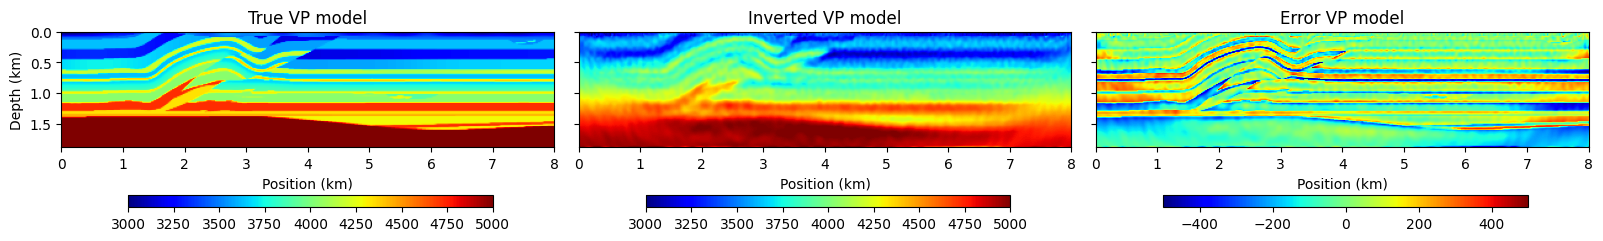

In [16]:
base_inv_vp = scipy.io.loadmat(fwi_result + 'BaseJointVP_.mat')
base_inv_vp = base_inv_vp['rec']

plot_true_inv(base_true_vp, base_inv_vp, np.array(dx)/1000, parameter='VP', diff=500)

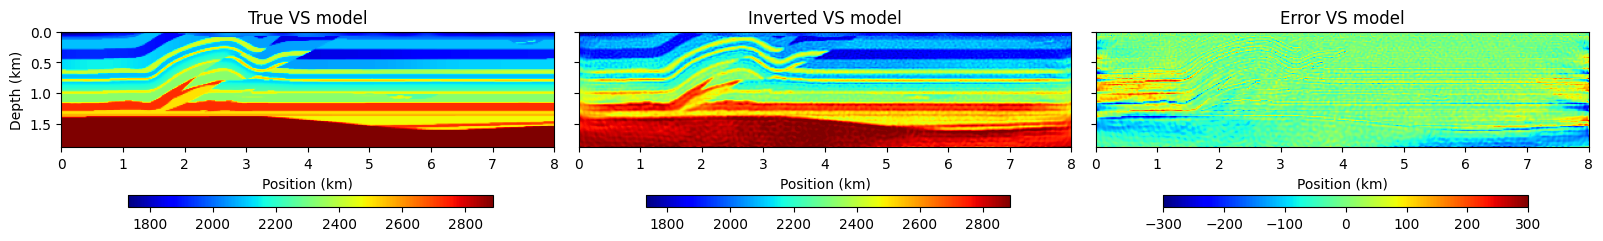

In [17]:
base_inv_vs = scipy.io.loadmat(fwi_result + 'BaseJointVS_.mat')
base_inv_vs = base_inv_vs['rec']

plot_true_inv(base_true_vs, base_inv_vs, np.array(dx)/1000, parameter='VS', diff=300)

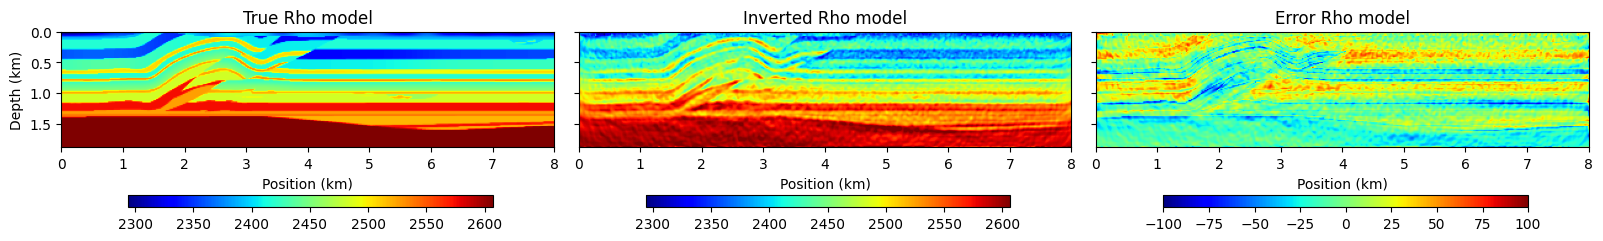

In [18]:
base_inv_rho = scipy.io.loadmat(fwi_result + 'BaseJointRho_.mat')
base_inv_rho = base_inv_rho['rec']

plot_true_inv(base_true_rho, base_inv_rho, np.array(dx)/1000, parameter='Rho', diff=100)

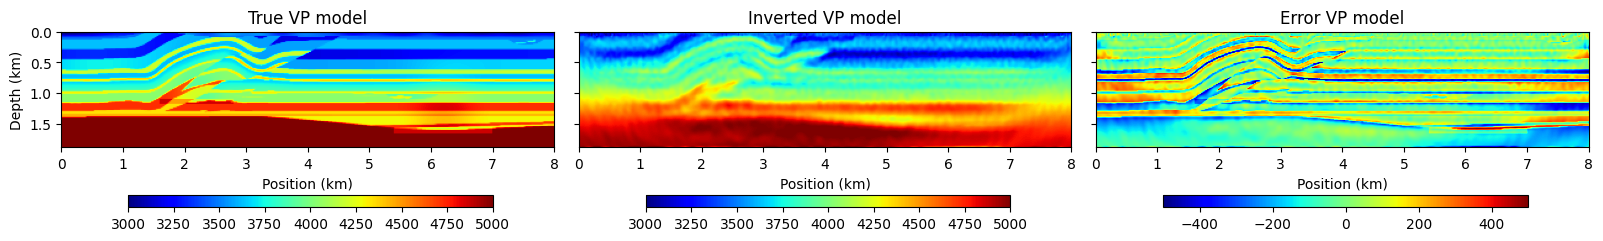

In [19]:
monitor_inv_vp = scipy.io.loadmat(fwi_result + 'MonitorJointVP_.mat')
monitor_inv_vp = monitor_inv_vp['rec']

plot_true_inv(monitor_true_vp, monitor_inv_vp, np.array(dx)/1000, parameter='VP', diff=500)

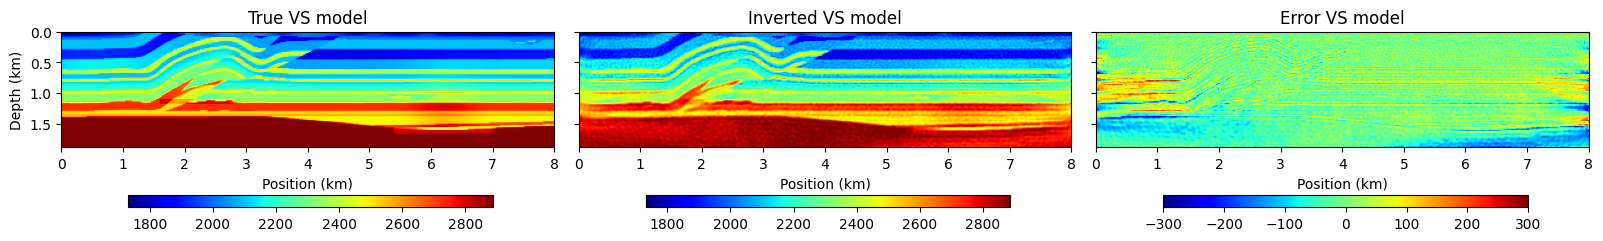

In [20]:
monitor_inv_vs = scipy.io.loadmat(fwi_result + 'MonitorJointVS_.mat')
monitor_inv_vs = monitor_inv_vs['rec']

plot_true_inv(monitor_true_vs, monitor_inv_vs, np.array(dx)/1000, parameter='VS', diff=300)

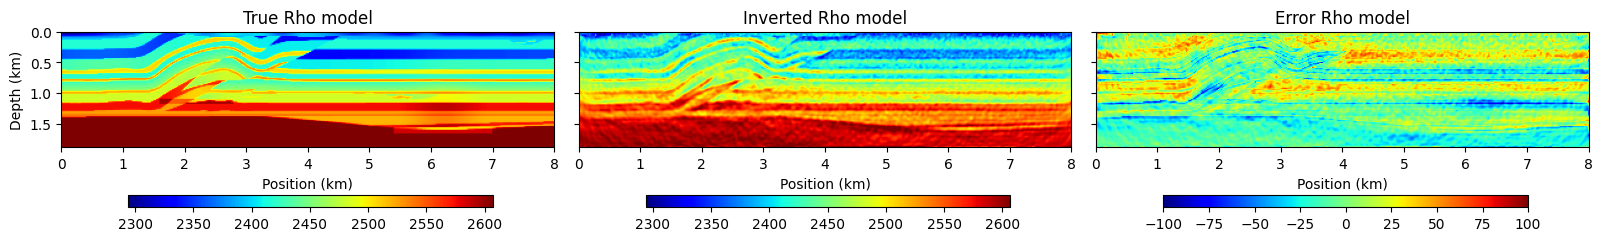

In [21]:
monitor_inv_rho = scipy.io.loadmat(fwi_result + 'MonitorJointRho_.mat')
monitor_inv_rho = monitor_inv_rho['rec']

plot_true_inv(monitor_true_rho, monitor_inv_rho, np.array(dx)/1000, parameter='Rho', diff=100)

## Difference Joint Regularized approach

/home/bermanu/Ulises/Advanced_Seismic_Inversion/Project/ElasticSiameseFWI-pub/utils/utils.py:839: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout();


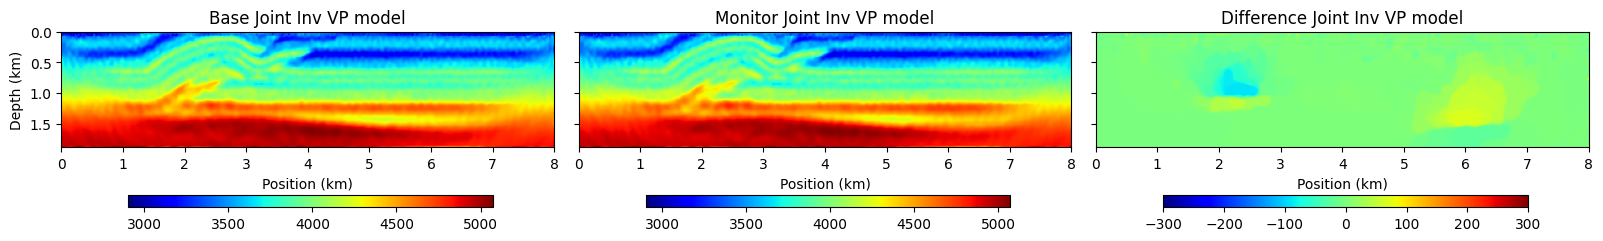

In [22]:
plot_base_monitor(base_inv_vp, monitor_inv_vp, np.array(dx)/1000, parameter='Joint Inv VP', diff=300)

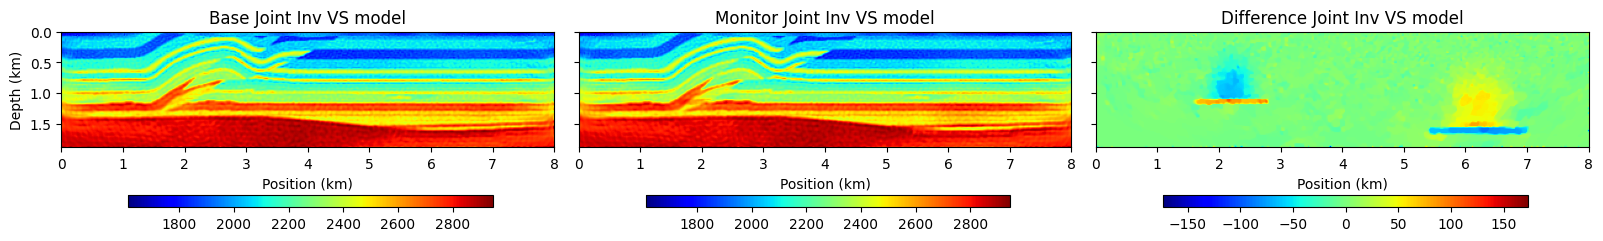

In [23]:
plot_base_monitor(base_inv_vs, monitor_inv_vs, np.array(dx)/1000, parameter='Joint Inv VS', diff=300/np.sqrt(3))

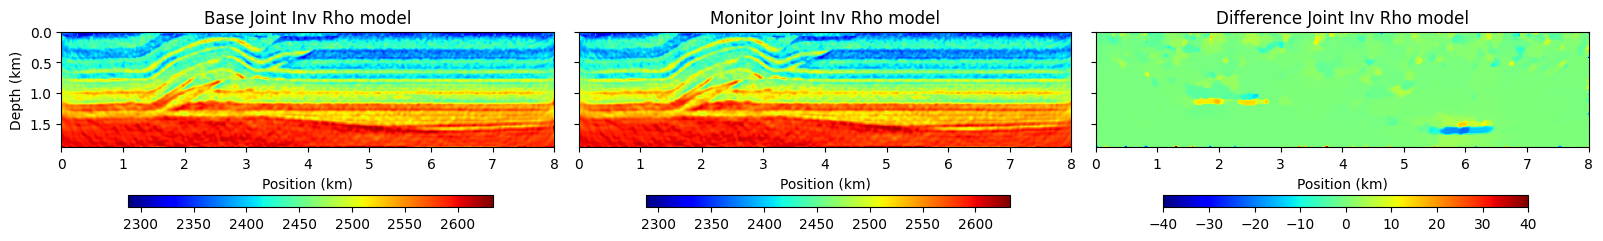

In [24]:
plot_base_monitor(base_inv_rho, monitor_inv_rho, np.array(dx)/1000, parameter='Joint Inv Rho', diff=40)

In [25]:
time_lapse_vp = monitor_inv_vp - base_inv_vp
time_lapse_vs = monitor_inv_vs - base_inv_vs
time_lapse_rho = monitor_inv_rho - base_inv_rho

/tmp/ipykernel_5541/3348847415.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout();


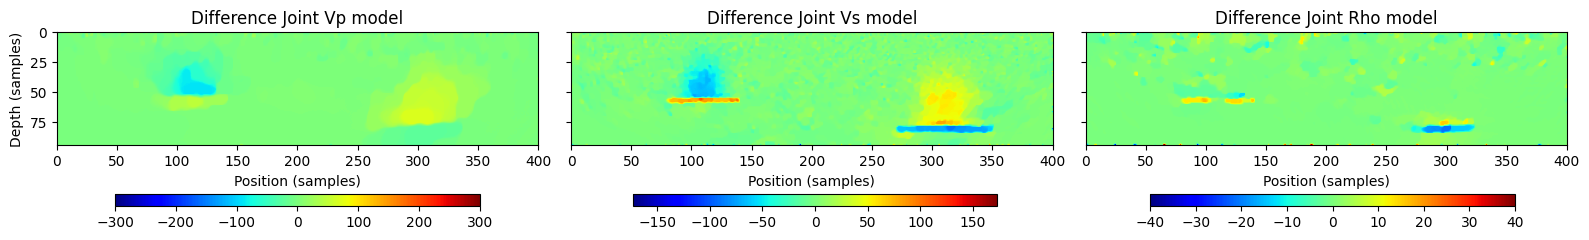

In [26]:
# Do a 1x3 plot showing true base, monitor and difference models
fig, axs = plt.subplots(1, 3, figsize=(16, 6), sharey=True)
# Plot true model
vmin=-300
vmax=300
im = axs[0].imshow(time_lapse_vp, vmin=vmin, vmax=vmax, cmap='jet', \
              extent=[0, monitor_inv_vp.shape[1], monitor_inv_vp.shape[0], 0])
axs[0].set_title('Difference Joint Vp model')
axs[0].set_xlabel('Position (samples)')
axs[0].set_ylabel('Depth (samples)')

pos = axs[0].get_position()
cbar_ax = fig.add_axes([pos.x0 - 0.05, pos.y0 - 0.12, pos.width, 0.02])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

# Plot monitor model
vmin=-300/np.sqrt(3)
vmax=300/np.sqrt(3)
im = axs[1].imshow(time_lapse_vs, vmin=vmin, vmax=vmax, cmap='jet', \
                   extent=[0, monitor_inv_vp.shape[1], monitor_inv_vp.shape[0], 0])
axs[1].set_title('Difference Joint Vs model')
axs[1].set_xlabel('Position (samples)')

pos = axs[1].get_position()
cbar_ax = fig.add_axes([pos.x0, pos.y0 - 0.12, pos.width, 0.02])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
# Plot difference model
vmin=-40
vmax=40
im = axs[2].imshow(time_lapse_rho, vmin=vmin, vmax=vmax, cmap='jet', \
                   extent=[0, monitor_inv_vp.shape[1], monitor_inv_vp.shape[0], 0])
axs[2].set_title('Difference Joint Rho model')
axs[2].set_xlabel('Position (samples)')

pos = axs[2].get_position()
cbar_ax = fig.add_axes([pos.x0 + 0.05, pos.y0 - 0.12, pos.width, 0.02])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

plt.tight_layout();